In [1]:
pip install opendatasets


     ---------------------------------------- 0.0/83.6 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/83.6 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/83.6 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/83.6 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/83.6 kB ? eta -:--:--
     ------------- ------------------------ 30.7/83.6 kB 100.9 kB/s eta 0:00:01
     ------------- ------------------------ 30.7/83.6 kB 100.9 kB/s eta 0:00:01
     ------------------- ------------------- 41.0/83.6 kB 98.1 kB/s eta 0:00:01
     ------------------- ------------------- 41.0/83.6 kB 98.1 kB/s eta 0:00:01
     --------------------------- ---------- 61.4/83.6 kB 109.2 kB/s eta 0:00:01
     -------------------------------- ----- 71.7/83.6 kB 112.3 kB/s eta 0:00:01
     -------------------------------------- 83.6/83.6 kB 130.3 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): f

ERROR: Could not install packages due to an OSError: [WinError 2] Le fichier spécifié est introuvable: 'c:\\Python311\\Scripts\\slugify.exe' -> 'c:\\Python311\\Scripts\\slugify.exe.deleteme'



In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k")

ModuleNotFoundError: No module named 'opendatasets'

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('/content/ocular-disease-recognition-odir5k/full_df.csv')

In [ ]:
df.describe()

,ID,Patient Age,N,D,G,C,A,H,M,O
count,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000
mean,2271.150814,57.857947,0.328692,0.332134,0.062109,0.062891,0.049906,0.031758,0.047872,0.248436
std,1417.559018,11.727737,0.469775,0.471016,0.241372,0.242786,0.217768,0.175370,0.213513,0.432139
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,920.750000,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2419.500000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3294.000000,66.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4784.000000,91.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
def has_cataract(text):
    if "cataract" in text:
        return 1

In [ ]:
def is_normal(text):
    if "normal fundus" in text:
        return 1

In [ ]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
left_cataract = df.loc[(df.C == 1) & (df['left_cataract'] == 1)]["Left-Fundus"].values
right_cataract = df.loc[(df.C == 1) & (df['right_cataract'] == 1)]["Right-Fundus"].values

In [ ]:
df["left_normal"] = df["Left-Diagnostic Keywords"].apply(lambda x: is_normal(x))
df["right_normal"] = df["Right-Diagnostic Keywords"].apply(lambda x: is_normal(x))
left_normal = df.loc[(df.N ==1) & (df["left_normal"] == 1)]["Left-Fundus"].sample(300, random_state=42).values
right_normal = df.loc[(df.N ==1) & (df['right_normal'] == 1)]["Right-Fundus"].sample(300, random_state=42).values


In [ ]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)


print(len(cataract))
print(len(normal))

594
600


In [ ]:
from tqdm import tqdm
import cv2
import os, random

dataset_dir = "/content/ocular-disease-recognition-odir5k/preprocessed_images"
labels = []
dataset = []
image_size=224
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)

            #Pretraitement d'images
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image,(image_size,image_size)) # Redimensionnement
            image = image / 255.0  # Normalisation des pixels entre 0 et 1

        except:
            continue

        dataset.append([np.array(image),np.array(label)])

    random.shuffle(dataset)
    return dataset


In [ ]:
dataset = create_dataset(cataract,1)

100%|██████████| 594/594 [00:33<00:00, 17.72it/s]


In [ ]:
dataset = create_dataset(normal,0)

100%|██████████| 600/600 [00:08<00:00, 69.81it/s]


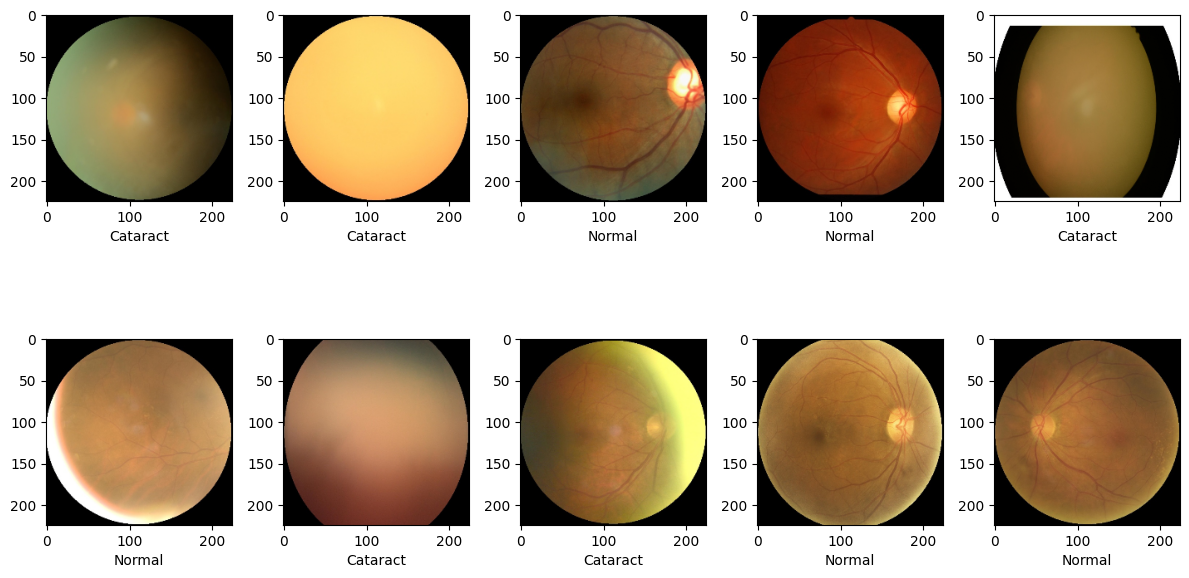

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    elif category == 1:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

In [ ]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size, 3)
y = np.array([i[1] for i in dataset])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=45)

datagen.fit(x_train)

In [ ]:
from tensorflow.keras.applications import VGG19
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model


base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False


219055592/219055592 [==============================] - 20s 0us/step


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 5, 5, 1536)        54336736  
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 38400)             0         
                                                                 
 dense (Dense)               (None, 1)                 38401     
                                                                 
Total params: 54375137 (207.42 MB)
Trainable params: 38401 (150.00 KB)
Non-trainable params: 54336736 (207.28 MB)
_________________________________________________________________


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import tensorflow as tf
import seaborn as sns

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='auc')])

In [ ]:
batch_size = 32
epochs = 15

In [ ]:
model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
          steps_per_epoch=len(x_train) // batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test), verbose=1)

Epoch 1/15
29/29 [==============================] - 57s 1s/step - loss: 1.0895 - accuracy: 0.8538 - precision: 0.8549 - recall: 0.8531 - auc: 0.9006 - val_loss: 0.6618 - val_accuracy: 0.9364 - val_precision: 0.9720 - val_recall: 0.8966 - val_auc: 0.9412
Epoch 2/15
29/29 [==============================] - 20s 680ms/step - loss: 0.5093 - accuracy: 0.9209 - precision: 0.9243 - recall: 0.9161 - auc: 0.9537 - val_loss: 0.2060 - val_accuracy: 0.9449 - val_precision: 0.9640 - val_recall: 0.9224 - val_auc: 0.9796
Epoch 3/15
29/29 [==============================] - 21s 714ms/step - loss: 0.3277 - accuracy: 0.9231 - precision: 0.9268 - recall: 0.9187 - auc: 0.9663 - val_loss: 0.2575 - val_accuracy: 0.9364 - val_precision: 0.9720 - val_recall: 0.8966 - val_auc: 0.9771
Epoch 4/15
29/29 [==============================] - 20s 692ms/step - loss: 0.3055 - accuracy: 0.9143 - precision: 0.9147 - recall: 0.9147 - auc: 0.9663 - val_loss: 0.4671 - val_accuracy: 0.8814 - val_precision: 0.8284 - val_recall: 

In [ ]:
# Évaluez le modèle sur les données de test
loss, accuracy, precision, recall, auc_score = model.evaluate(x_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc_score)


8/8 [==============================] - 3s 400ms/step - loss: 0.2484 - accuracy: 0.9534 - precision: 0.9730 - recall: 0.9310 - auc: 0.9796
Loss: 0.24838922917842865
Accuracy: 0.9533898234367371
Precision: 0.9729729890823364
Recall: 0.931034505367279
AUC: 0.9795976877212524


In [ ]:
from sklearn.metrics import confusion_matrix

# Obtenez les prédictions continues du modèle
y_pred_continuous = model.predict(x_test)

# Définissez un seuil de décision (par exemple, 0,5)
threshold = 0.5

# Convertissez les prédictions continues en valeurs binaires
y_pred_binary = (y_pred_continuous > threshold).astype(int)

# Calculez la matrice de confusion
cm = confusion_matrix(y_test, y_pred_binary)

# Imprimez la matrice de confusion
print(cm)


8/8 [==============================] - 8s 478ms/step
[[117   3]
 [  8 108]]
